# First Practical Session -- Haoxuan ZHANG

This first practical session will guide you into different registration methods you saw in the first 2 lessons.


There are 3 ways of characterize deformations models :
* **linear** model (matricial link) vs **non-linear** model 
* **local** model (each parameter influences restricted area) vs **global** model (each parameter influences the whole image)
* **parametric** model (explicit formulation of deformation field) vs **non-parametric model** (no explicit formulation, optimisation problem)

In the first 2 lessons you saw global, linear and local, non-linear models, that you will **implement** in this labwork.

The registration is defined by 
\begin{equation*}
\Phi(x_i) \approx y_i
\end{equation*}

for each $x_i$, point of $I_{reca}$.




In [67]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib as mpl 

from numpy.linalg import inv 
import copy 

mpl.rcParams['image.origin'] = 'upper'
%matplotlib inline

## Plot functions

The functions below are provided, and will be called in specific piece of code you will see later. You don't need to take care about it, except if you want to understand all the process of visualization of course.

In [68]:
def plot_grid_def(nr,nc,vX,vY,axes=None):
    
    '''
    Returns a grid of the deformation field computed with displacements fields vX and vY. 
    ---
    nr : number of rows in image
    nc : number of columns in image
    vX, vY : displacement fields of n points in X and Y directions.
    '''
        
    xgrid,ygrid = np.meshgrid(np.arange(0,nr,20),np.arange(0,nc,20))

    XgD = xgrid + vX.reshape(xgrid.shape)
    YgD = ygrid + vY.reshape(ygrid.shape)
    
    if axes is None :
        plt.figure()
        for k in range(np.shape(XgD)[0]):
            plt.plot(XgD[k,:],YgD[k,:],'-k')

        for k in range(np.shape(XgD)[1]):
            plt.plot(XgD[:,k],YgD[:,k],'-k')
        plt.show()
    else:
        for k in range(np.shape(XgD)[0]):
            axes.plot(XgD[k,:],YgD[k,:],'-k')

        for k in range(np.shape(XgD)[1]):
            axes.plot(XgD[:,k],YgD[:,k],'-k')

## Data importation and transformation

The guideline for this practical session and the next ones on registration will be anchors : 
-  $I_{ref}$ : the red anchor, is the reference (or target) image 
-  $I_{reca}$  : the grey anchor, is the picture to register


Here landmarks are already provided, in a .npy object.


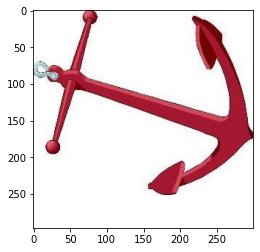

In [69]:
Iref = mpimg.imread('./Images/image_redanch.jpg') 
Ireca = mpimg.imread('./Images/image_greyanch.jpg')

# Output Image - padding
Iref = np.concatenate((Iref,255*np.ones((45,300,3),dtype=np.int8)),axis=0)

plt.imshow(Iref) 
plt.show()

In [70]:
# zero-padding to avoid out-of-bounds problems when one moves images
nr,nc,_ = Ireca.shape

pad = 255*np.ones((nr,nc,3),dtype=np.int8);
Iref = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,Iref,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)
Ireca = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,Ireca,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)

# positions of "utils pixels"
rutil = np.arange(nr,(2*nr))
cutil = np.arange(nc,(2*nc))

### Original images

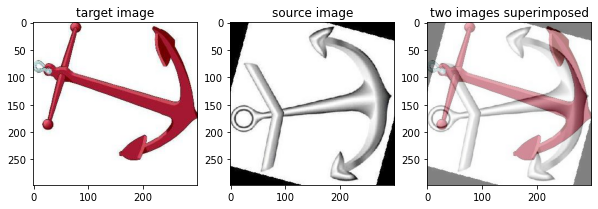

In [71]:
# display original images
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(Iref[:,cutil,:][rutil])
plt.title('target image')
plt.subplot(1,3,2)
plt.imshow(Ireca[:,cutil,:][rutil])
plt.title('source image')
plt.subplot(1,3,3)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Ireca[:,cutil,:][rutil],alpha=0.5)
plt.title('two images superimposed')
plt.show()

### Original images with landmarks

In [72]:
# Preca and Pref are reference points in each picture : 
# Preca for image to register (grey anchor) and Pref for target image (red anchor).
Preca = np.load('./data/PsrcAnchors.npy') #(2 by 19) 
Pref = np.load('./data/PtarAnchors.npy') 
Npts = np.size(Preca,1)

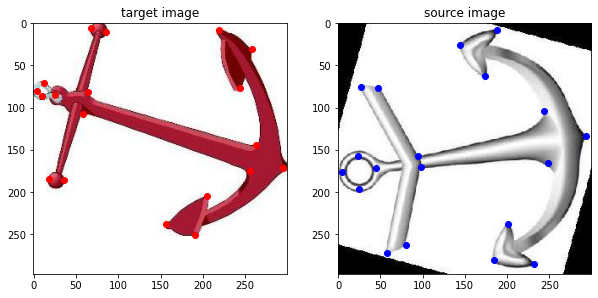

In [73]:
plt.figure(1,figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(Iref[:,cutil,:][rutil])
plt.plot(Pref[0,:],Pref[1,:],'or')
plt.title('target image')
plt.subplot(1,2,2)
plt.imshow(Ireca[:,cutil,:][rutil])
plt.plot(Preca[0,:],Preca[1,:],'ob')
plt.title('source image')
plt.show()

## Linear registrations

### Linear registration using triplets of points


**Instructions** :


In this first part, you have to implement the **linear registration using 3 landmarks**, as seen in first class.


You choose a set of 3 landmarks by writing indexes in the vector `PtsInd`. The corresponding landmarks are in `X1,X2, X3` for $I_{reca}$ and `Y1,Y2,Y3` for $I_{ref}$.

In [74]:
######### 
# You can choose here a triplet of points, 
# by given integers corresponding to indexes in arrays of landmarks.
PtsInd = [0,1,2] # this is a possible choice
# PtsInd = list(range(6,9))# this is another possible choice

# Coordinates of triplet for source images
X1 = Preca[:,PtsInd[0]]; X2 = Preca[:,PtsInd[1]]; X3 = Preca[:,PtsInd[2]]

# Coordinates of triplet for target image
Y1 = Pref[:,PtsInd[0]]; Y2 = Pref[:,PtsInd[1]]; Y3 = Pref[:,PtsInd[2]]

The next cell plots the source and target images superimposed with your three selected landmarks.

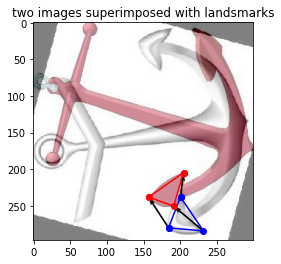

In [75]:
plt.figure()
## Images
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Ireca[:,cutil,:][rutil],alpha=0.5)
#Landmarks
plt.plot(Preca[0,PtsInd],Preca[1,PtsInd],'-ob',[Preca[0,PtsInd[2]],Preca[0,PtsInd[0]]],[Preca[1,PtsInd[2]],Preca[1,PtsInd[0]]],'-ob');
plt.plot(Pref[0,PtsInd],Pref[1,PtsInd],'-or',[Pref[0,PtsInd[2]],Pref[0,PtsInd[0]]],[Pref[1,PtsInd[2]],Pref[1,PtsInd[0]]],'-or');
# Arrows between images
plt.quiver(Preca[0,PtsInd],Preca[1,PtsInd],Pref[0,PtsInd]-Preca[0,PtsInd],Pref[1,PtsInd]-Preca[1,PtsInd],scale=300,angles='xy');
plt.title('two images superimposed with landsmarks')
plt.show()

**Below, you have to compute the parameters of affine tranformation, A and t, as seen in first lecture, using the 3 landmarks defined above.** 

#### Estimation of the affine registration parameters

In [76]:
'''
TO DO : compute A the affine transformation matrix 2x2, and t the translation vector 2x1 with 3 correspoding points.
----
A : array 2x2 
t : vector of size 2 (or array 2x1)  
'''

Y = np.zeros((2,2)) 
for i in range(len(Y)): 
    Y[i][0] = Y1[i] - Y2[i] 
    Y[i][1] = Y1[i] - Y3[i] 
print('Y =', Y) 

X = np.zeros((2,2)) 
for i in range(len(X)): 
    X[i][0] = X1[i] - X2[i] 
    X[i][1] = X1[i] - X3[i] 
print('X =', X) 

A = np.matmul(Y, inv(X)) 
print('A =', A) 

X_bar = (1/3) * (X1 + X2 + X3) 
Y_bar = (1/3) * (Y1 + Y2 + Y3) 
t     = Y_bar - np.matmul(A, X_bar) 
print('t =', t)

'''
TO DO : Compute the registration of the source landmarks. It corresponds to their position after affine transformation and translation. 
---
Xreg1, Xreg2, Xreg3 : array (2x1) or vector (2,)
'''

Xreg1 = np.matmul(A, X1) + t 
Xreg2 = np.matmul(A, X2) + t 
Xreg3 = np.matmul(A, X3) + t 

Y = [[-34.10138249 -47.74193548]
 [-12.23976608  33.22222222]]
X = [[-47.74193548 -16.36866359]
 [ -4.37134503  41.96491228]]
A = [[ 0.79022989 -0.82942931]
 [ 0.177546    0.86091954]]
t = [243.6568385  -35.71034386]


#### The deformation field

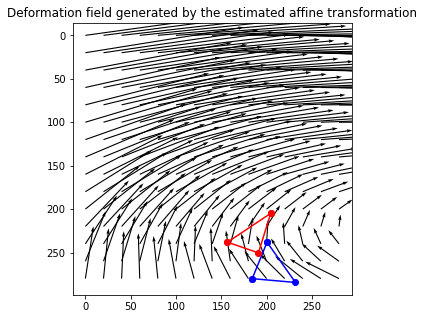

In [77]:
### A regular grid of points to register
xgrid, ygrid = np.meshgrid(np.arange(0,nc,20),np.arange(0,nr,20))
xgrid = xgrid.reshape(1,-1)
ygrid = ygrid.reshape(1,-1)
grid  = np.concatenate([xgrid,ygrid],axis=0) # array (2 by N)

'''
TO DO : Above is computed a regular grid in an array 2xN with two rows (one for x coordinates and one for y coordinates).

Compute the registration of this array with the affine registration parameters A and t.
----
gridReg : array (2,N), positions of grid points after affine transformation and translation following A and t.
'''

gridReg = copy.deepcopy(grid) 
for i in range(len(gridReg[0])): 
    position      = (grid[0][i], grid[1][i]) 
    registration  = np.matmul(A, position) + t 
    gridReg[0][i] = registration[0] 
    gridReg[1][i] = registration[1] 

###########################
# Below is the code to visualize the deformation of the regular grid. 
# It gives you intuition of the displacement of source image points to reach their wanted positions in registered image. 
plt.figure(3,figsize=(5,5))
plt.plot(Preca[0,PtsInd],Preca[1,PtsInd],'-ob',[Preca[0,PtsInd[2]],Preca[0,PtsInd[0]]],[Preca[1,PtsInd[2]],Preca[1,PtsInd[0]]],'-ob');
plt.plot(Pref[0,PtsInd],Pref[1,PtsInd],'-or',[Pref[0,PtsInd[2]],Pref[0,PtsInd[0]]],[Pref[1,PtsInd[2]],Pref[1,PtsInd[0]]],'-or');
plt.quiver(xgrid,ygrid,gridReg[0,:] - xgrid, gridReg[1,:] - ygrid,angles='xy',scale=400)
plt.gca().invert_yaxis()
plt.title('Deformation field generated by the estimated affine transformation')
plt.show()

#### Registration of the source image with the computed parameters A and t.

Now that you have your parameters A and t, you want to use them to compute the registration of your full source image (the grey anchor). 
During the lecture you saw that the action of the mapping on the image is defined by $I(\phi^{-1}(y))$.

By using $\phi^{-1}$ we can here compute the inverse transformation of a grid, given by $\phi^{-1}(grid)$. Then we match $\phi^{-1}(grid)$ and the $I_{reca}$  points.

Finally, with this matching, each point of $I_{reca}$ is moved to its registered position. It matches the target image.

**Your task here is to compute the inverse transformation of the grid, $\phi^{-1}(grid)$, the grid is given by x and y coordinates in vectors xim and yim.**


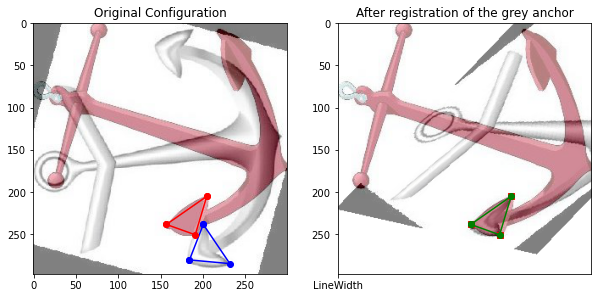

In [78]:
##################################################
# This code computes a grid given by two vectors:
# xim : 1 by nr*nc (x coordinates)
# yim : 1 by nr*nc (y coordinates)
# These vectors are used to find the corresponding position of each pixel between the source image and the registered image.
xim,yim = np.meshgrid(np.arange(0,nc),np.arange(0,nr))
xim = xim.reshape(1,-1)
yim = yim.reshape(1,-1)
gridim = np.concatenate([xim,yim],axis=0) 
################################################## 

'''
TO DO :
Compute the inverse transformation of a grid given by xim and yim.
----
gridRegInv : array 2 by N (N=nc*nr)
'''

gridRegInv = copy.deepcopy(gridim) 
for i in range(len(gridRegInv[0])): 
    position         = (gridim[0][i], gridim[1][i]) 
    registration     = np.matmul(inv(A), position - t) 
    gridRegInv[0][i] = registration[0] 
    gridRegInv[1][i] = registration[1] 

##############################
# This code computes the registered image by finding the correspondence 
# between a source pixel and its position in the registered image.
# For each pixel i of gridReg in the target image space :
# 1. find the corresponding pixel in the source image (position given by gridRegInv[:,i])
# 2. assign this source pixel value to the corresponding registered pixel in Jreg (the registered image).
# We obtain Jreg, the registered image.

Jreg = np.zeros((nr,nc,3))
for i in range(xim.shape[1]):
    value_source = Ireca[int(round(gridRegInv[1,i]) + nr), int(round(gridRegInv[0,i]) + nc)]
    Jreg[yim[:,i],xim[:,i],:] = value_source

Jreg = Jreg/255. # array (nr*nc*3)

#######################
# Below we plot the original configuration of our anchors, 
# and the final position after registration of the grey anchor.
######################

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Ireca[:,cutil,:][rutil],alpha=0.5)
plt.plot(Preca[0,PtsInd],Preca[1,PtsInd],'-ob',[Preca[0,PtsInd[2]],Preca[0,PtsInd[0]]],[Preca[1,PtsInd[2]],Preca[1,PtsInd[0]]],'-ob')
plt.plot(Pref[0,PtsInd],Pref[1,PtsInd],'-or',[Pref[0,PtsInd[2]],Pref[0,PtsInd[0]]],[Pref[1,PtsInd[2]],Pref[1,PtsInd[0]]],'-or')
plt.title('Original Configuration')

plt.subplot(1,2,2)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Jreg,alpha=0.5)
plt.plot(Pref[0,PtsInd],Pref[1,PtsInd],'sr','LineWidth',2)
plt.plot([Xreg1[0],Xreg2[0],Xreg3[0],Xreg1[0]],[Xreg1[1],Xreg2[1],Xreg3[1],Xreg1[1]],'-og','LineWidth',2)
plt.title('After registration of the grey anchor')
plt.show()

### Registration driven by  n landmarks

Now you have to **compute registration with the full set of landmarks in each image.**
It corresponds to the part 2.2.2 in the lecture notes.

The set of source landmarks is given by array **Preca**.

#### Estimation of the affine registration parameters

In [79]:
# Coordinates of triplet for source images : Preca (2*19) 
# Coordinates of triplet for target image : Pref (2*19) 

'''
TO DO : compute A the affine transformation matrix 2x2, and t the translation vector 2x1 with n correspoding points.
n
A : array 2 by 2 
t : vector of size 2 (or array 2 by 1)  
'''

Xn_bar = np.average(Preca, axis=1) 
Yn_bar = np.average(Pref, axis=1) 

Xn_tilde = copy.deepcopy(Preca) 
for i in range(len(Preca[0])): 
    position       = (Preca[0][i], Preca[1][i]) 
    registration   = position - Xn_bar 
    Xn_tilde[0][i] = registration[0] 
    Xn_tilde[1][i] = registration[1] 
    
Yn_tilde = copy.deepcopy(Pref) 
for i in range(len(Pref[0])): 
    position       = (Pref[0][i], Pref[1][i]) 
    registration   = position - Yn_bar 
    Yn_tilde[0][i] = registration[0] 
    Yn_tilde[1][i] = registration[1] 

An = np.matmul(np.matmul(Yn_tilde, np.transpose(Xn_tilde)), inv(np.matmul(Xn_tilde, np.transpose(Xn_tilde)))) 
tn = Yn_bar - np.matmul(An, Xn_bar) 

'''
TO DO :
Compute the registration of the source landmarks. It corresponds to their position after affine transformation and translation. 
----
Preg : array 2 by n_landmarks
'''

Preg = copy.deepcopy(Preca) 
for i in range(len(Preca[0])): 
    position = (Preca[0][i], Preca[1][i]) 
    registration = np.matmul(An, position) + tn 
    Preg[0][i] = registration[0] 
    Preg[1][i] = registration[1]  

#### The deformation field

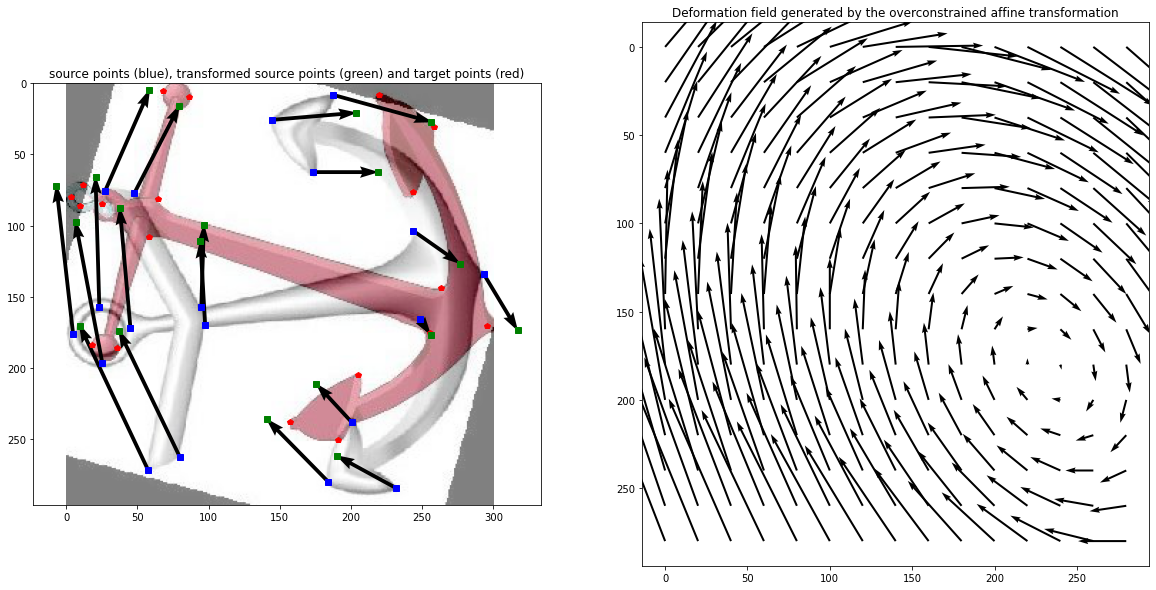

In [80]:
### A regular grid of points to register
xgrid,ygrid = np.meshgrid(np.arange(0,nc,20),np.arange(0,nr,20));
xgrid = xgrid.reshape(1,-1)
ygrid = ygrid.reshape(1,-1)
grid  = np.concatenate([xgrid,ygrid],axis=0) # array (2 by N)

'''
TO DO : Above is computed a regular grid in an array 2xN with two rows (one for x coordinates and one for y coordinates).

Compute the registration of this array with the affine registration parameters A and t.
----
gridReg : array 2xN, positions of grid points after affine transformation and translation following A and t.
'''

gridReg = copy.deepcopy(grid) 
for i in range(len(gridReg[0])): 
    position      = (grid[0][i], grid[1][i]) 
    registration  = np.matmul(An, position) + tn 
    gridReg[0][i] = registration[0] 
    gridReg[1][i] = registration[1] 

###########################
# Below is the code to visualize the deformation of the regular grid. 
# It gives you intuition of the displacement of source image points to reach their wanted positions in registered image. 

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Ireca[:,cutil,:][rutil],alpha=0.5)
plt.plot(Preca[0,:],Preca[1,:],'sb');
plt.plot(Pref[0,:],Pref[1,:],'pr');
plt.plot(Preg[0,:],Preg[1,:],'sg')
plt.quiver(Preca[0,:],Preca[1,:],Preg[0,:]-Preca[0,:],Preg[1,:]-Preca[1,:],scale=350,angles='xy')
plt.title('source points (blue), transformed source points (green) and target points (red)')

plt.subplot(1,2,2)
plt.quiver(xgrid,ygrid,gridReg[0,:] - xgrid, gridReg[1,:] - ygrid,angles='xy',scale=400)
plt.title('Deformation field generated by the overconstrained affine transformation')
plt.gca().invert_yaxis()
plt.show()


#### Registration of the source image with the computed parameters A and t.

These are the same formulas and the same process as with 3 landmarks.


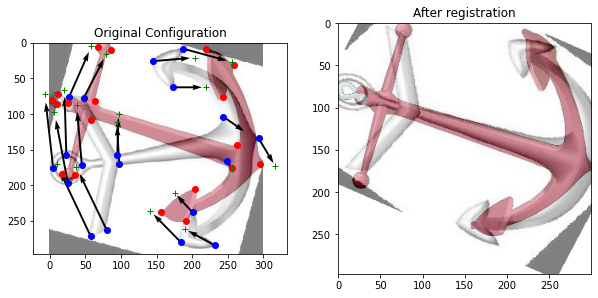

In [81]:
##################################################
# This code computes a grid given by two vectors:
# xim : 1 by nr*nc (x coordinates)
# yim : 1 by nr*nc (y coordinates)
# These vectors are used to find the corresponding position of each pixel between the source image and the registered image.
xim,yim = np.meshgrid(np.arange(0,nc),np.arange(0,nr));
xim = xim.reshape(1,-1)
yim = yim.reshape(1,-1)
gridim = np.concatenate([xim,yim],axis=0) 

'''
TO DO :
Compute the inverse transformation of a grid given by xim and yim.
----
gridRegInv : array 2 by N (N=nc*nr)
'''
 
gridRegInv = copy.deepcopy(gridim) 
for i in range(len(gridRegInv[0])): 
    position         = (gridim[0][i], gridim[1][i]) 
    registration     = np.matmul(inv(An), position - tn) 
    gridRegInv[0][i] = registration[0] 
    gridRegInv[1][i] = registration[1] 

##############################
# This code computes the registered image by finding the correspondence 
# between a source pixel and its position in the registered image.
# For each pixel i of gridReg in the target image space :
# 1. find the corresponding pixel in the source image (position given by gridRegInv[:,i])
# 2. assign this source pixel value to the corresponding registered pixel in Jreg (the registered image).
# We obtain Jreg, the registered image.

Jreg = np.zeros((nr,nc,3))
for i in range(xim.shape[1]):
    value = Ireca[int(round(gridRegInv[1,i]) + nr), int(round(gridRegInv[0,i]) + nc),:]
    Jreg[yim[:,i],xim[:,i],:] = value

Jreg = Jreg/255.  # array (nr*nc*3)

#######################
# Below we plot the original configuration of our anchors, 
# and the final position after registration of the grey anchor.
######################

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Ireca[:,cutil,:][rutil],alpha=0.5)
plt.plot(Preca[0,:],Preca[1,:],'ob')
plt.plot(Pref[0,:],Pref[1,:],'or')
plt.plot(Preg[0,:],Preg[1,:],'+g')
plt.quiver(Preca[0,:],Preca[1,:],Preg[0,:]-Preca[0,:],Preg[1,:]-Preca[1,:],scale=400,angles='xy')
plt.title('Original Configuration')

plt.subplot(1,2,2)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Jreg,alpha=0.5)
plt.title('After registration')
plt.show()

**Q: How is the registered image now ?** 
**What are the limitations of this method ?** 

Even though the triangle part of the image no longer matches perfectly, the overall registrated image has a better matching. Hence, it gives an accurate a global deformation and a weaker local deformation. However, this method would not work if there are non-linear transformations. 

## Non-linear registration - small deformations

### Few landmarks - close-up

We load a new set of landmarks for both images.

In [82]:
Preca3 = np.load('./data/PsrcAnchors3.npy')
Pref3 = np.load('./data/PtarAnchors3.npy') 
n_landmarks = Preca3.shape[1]
print('We have now '+str(n_landmarks)+' landmarks.')

We have now 26 landmarks.


#### Affine registration step

Before to implement local small transformations, we apply the overconstrained affine registration studied in the previous section, **with the already computed parameters A and t (DO NOT compute them again !!!)** from 1.3.2 (Registration driven by n landmarks).

This corresponds to a preprocessing step, which gives us "intermediate" image and landmarks: a grey anchor registered with the affine transformation and corresponding registered landmarks.
Then we will compute the local deformation on this "intermediate" image. 

**Instructions** :

**Compute below the affine registration of the new landmarks Preca3**. 
We use the same image $I_{reca}$  as in previous parts.
So the affine registered image is already in the array `Jreg`.

**In the remainder of this section, you will only use `Preg3` and `Jreg` (no more `Preca3` and `Ireca`).**


In [83]:
# Affine transformation of new landmarks with precedent parameters A and t.

'''
TO DO : Compute the registration of the source landmarks Preca3 with aleady estimated parametrs A and t from previous part. 
It corresponds to their position after affine transformation and translation. 
---
Preg3 : array 2 by n_landmarks
'''

Preg3 = copy.deepcopy(Preca3) 
for i in range(len(Preca3[0])): 
    position     = (Preca3[0][i], Preca3[1][i]) 
    registration = np.matmul(An, position) + tn 
    Preg3[0][i]  = registration[0] 
    Preg3[1][i]  = registration[1] 

######################
# Registered image Jreg from previous section with padding, you don't have to touch it.
JregA = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,255.*Jreg,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)/255


Below you can select a set of 3 landmarks as in the first part, or you can decide to consider all the landmarks from Preg3. 
The code thereafter display your selection of landmarks in `Preg3` and their positions after overconstrained affine registration.

In [84]:
######### 
# You can choose here a triplet of points, 
# by given integers corresponding to indexes in arrays of landmarks.
PtsInd = [5,12,25] # selects the index of the landmark here
Npts = len(PtsInd)

##### Or you can select all landmarks
# PtsInd = np.arange(0,n_landmarks)
# Npts = len(PtsInd)

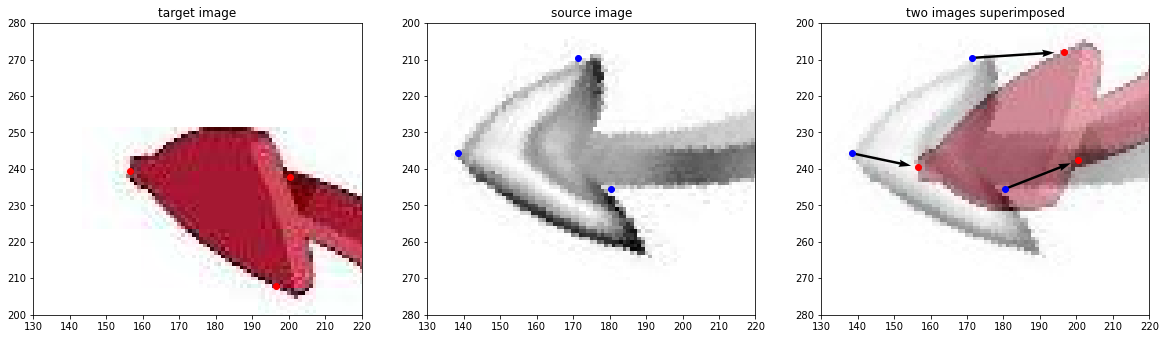

In [85]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Iref[:,cutil,:][rutil]);
plt.plot(Pref3[0,PtsInd],Pref3[1,PtsInd],'or')
plt.title('target image');
plt.axis([130,220,280,200])
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.plot(Preg3[0,PtsInd],Preg3[1,PtsInd],'ob')
plt.imshow(Jreg,origin='upper')
plt.axis([130,220,280,200])
plt.title('source image')

plt.subplot(1,3,3)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Jreg,alpha=0.5)
plt.plot(Preg3[0,PtsInd],Preg3[1,PtsInd],'ob')
plt.plot(Pref3[0,PtsInd],Pref3[1,PtsInd],'or')
plt.quiver(Preg3[0,PtsInd],Preg3[1,PtsInd],Pref3[0,PtsInd]-Preg3[0,PtsInd],Pref3[1,PtsInd]-Preg3[1,PtsInd],scale=100,angles='xy')
plt.axis([130,220,280,200])
plt.title('two images superimposed')

plt.show()

Above you have a focus on the overconstrained affine registration results. We can clearly see here that transformations affected the whole image, but shapes are still not matching. Now, you will implement kernel methods to register more precisely anchor images.

#### Computation of non linear registration - small deformations

You can find below the parameters of the gaussian kernel. **You can change these values after having computed everything**.
Keep these variable's names in your code.

In [86]:
## To PLAY WITH
gam = 0.5
sigma = 25 

**Instructions**:



- Compute **K the gaussian kernel** of the global deformation of your selected landmarks. 
- Compute the **momenta alphaX and alphaY**. You will need these estimates to compute all your next displacement vectors.  
- Compute **gammaX and gammaY** the displacements of your landmarks along vector v(landmark).



In [87]:
'''
TO DO:
Compute K gaussian kernel (use previously defined parameters gam and sigma),
momenta alphaX, alphaY and the displacement vector of each landmark, given by gammaX and gammaY.
----
K : array Npts x Npts (Npts is the number of landmarks you consider)
alphaX : array Npts x 1
alphaY : array Npts x 1
(or compute directly alpha: array Npts x 2 ) 
gammaX : array Npts x 1
gammaY : array Npts x 1
'''

X = [[], []] 
for index in PtsInd: 
    X[0].append(Preg3[0][index]) 
    X[1].append(Preg3[1][index]) 
X = np.array(X) 

Y = [[], []] 
for index in PtsInd: 
    Y[0].append(Pref3[0][index]) 
    Y[1].append(Pref3[1][index]) 
Y = np.array(Y) 

n = len(PtsInd) 
K = np.zeros((n, n)) 
for i in range(n): 
    for j in range(n): 
        K[i][j] = np.exp(- ((X[0][i] - X[0][j])**2 + (X[1][i] - X[1][j])**2) / sigma**2) 

alpha  = np.matmul(inv(K + gam*np.identity(3)), np.transpose(Y - X)) 
alphaX = np.zeros((n, 1)) 
alphaY = np.zeros((n, 1)) 
for i in range(n): 
    alphaX[i] = alpha[i][0] 
    alphaY[i] = alpha[i][1] 

gammaX = np.zeros((n, 1)) 
gammaY = np.zeros((n, 1)) 
for i in range(n): 
    for j in range(n): 
        gammaX[i] += K[i][j] * alphaX[j] 
        gammaY[i] += K[i][j] * alphaY[j] 


**Instructions:**

- Compute below the **deformation kernel Kr** of a grid defined by coordinates xim and yim, which has the same size than the source image. 
- Code the displacement vectors gX and gY of this grid. 
- Find the original position (in the source image) of registered points by inverse transformation of this grid (Section 3.1.2 of lectures).

In [88]:
##################################################
# This code computes a grid given by two vectors:
# xim : nr*nc by 1 (x coordinates)
# yim : nr*nc by 1 (y coordinates)
# These vectors are used to find the corresponding position of each pixel between the source image and the registered image.
xim,yim = np.meshgrid(np.arange(0,nc),np.arange(0,nr))
xim = xim.reshape(-1,1)
yim = yim.reshape(-1,1)

'''
TO DO :

Compute the kernel values Kr, and by following the displacement vectors gX and gY of the grid points (using alphaX and alphaY computed above).
Then compute the inverse transformation of the grid points (xim,yim) in RegInvX, regInvY.
-----
Kr : array nr*nc x Npts
gX : array nr*nc x 1
gY : array nr*nc x 1
RegInvX : array nr*nc x 1
RegInvY : array nr*nc x 1

'''
n1 = len(PtsInd) 
n2 = len(xim) 

Kr = np.zeros((n2, n1)) 
for i in range(n2): 
    for j in range(n1): 
        Kr[i][j] = np.exp(- ((xim[i] - X[0][j])**2 + (yim[i] - X[1][j])**2) / sigma**2) 

gX = np.zeros((n2, 1)) 
gY = np.zeros((n2, 1)) 
for i in range(n2): 
    for j in range(n1): 
        gX[i] += Kr[i][j] * alphaX[j] 
        gY[i] += Kr[i][j] * alphaY[j] 

RegInvX = xim - gX 
RegInvY = yim - gY 

##############################
# This code computes the registered image by finding the correspondence 
# between a source pixel and its position in the registered image.
# For each pixel i of gridReg in the target image space :
# 1. find the corresponding pixel in the source image JregA (position given by RegInvX[i] and RegInvY)
# 2. assign this source pixel value to the corresponding registered pixel in Jreg (the registered image).
# We obtain JregNL, the registered image.

JregNL = np.zeros((nr,nc,3))
for i in range(xim.shape[0]):
    value = JregA[int(round(RegInvY[i,0]) + nr), int(round(RegInvX[i,0]) + nc),:]
    JregNL[yim[i],xim[i],:] = value

    

#### The displacement field (optional)

If you want to observe the displacement field of a regular grid you can compute here the kernel of a regular grid, and the associated displacement of points with `vX` and `vY`. \
Then to use the computed field, you can uncomment the corresponding line in plot code in the next cell.

In [89]:
# A grid with coordinates of pixels 
xgrid,ygrid = np.meshgrid(np.arange(130,220,5),np.arange(200,280,5))
xgrid = xgrid.reshape(-1,1)
ygrid = ygrid.reshape(-1,1)

'''
TO DO:
Compute the kernel values Kgrid of the grid above and the associated displacement vectors.
-----
Kgrid: array len(xgrid) x Npts (Npts is the number of landmarks you consider)
vX: array len(xgrid) x 1
vY: array len(xgrid) x 1
''' 

n2 = len(xgrid) 

Kgrid = np.zeros((n2, n1)) 
for i in range(n2): 
    for j in range(n1): 
        Kgrid[i][j] = np.exp(- ((xgrid[i] - X[0][j])**2 + (ygrid[i] - X[1][j])**2) / sigma**2) 

vX = np.dot(Kgrid, alphaX)
vY = np.dot(Kgrid, alphaY)

#### Plots

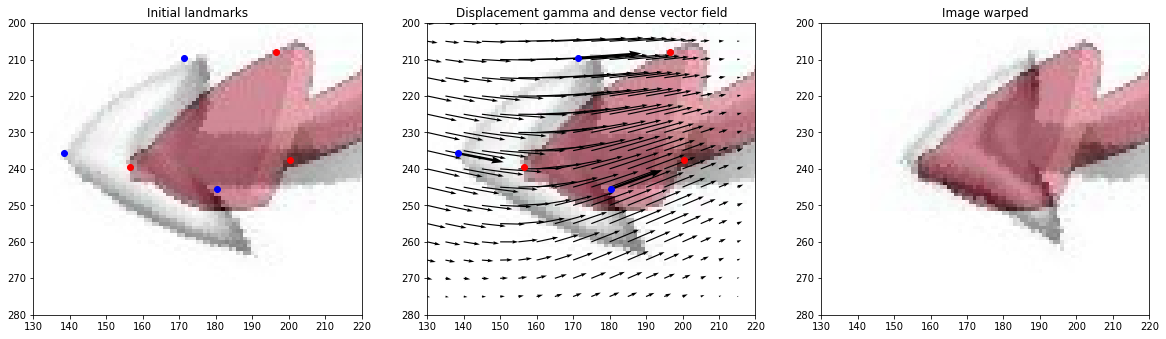

In [90]:
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(Iref[:,cutil,:][rutil]);
plt.imshow(JregA[:,cutil,:][rutil],alpha=0.5)
plt.plot(Pref3[0,PtsInd],Pref3[1,PtsInd],'or')
plt.plot(Preg3[0,PtsInd],Preg3[1,PtsInd],'ob')
plt.title('Initial landmarks');
plt.axis([130,220,280,200])


plt.subplot(1,3,2)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(JregA[:,cutil,:][rutil],alpha=0.5)
plt.plot(Pref3[0,PtsInd],Pref3[1,PtsInd],'or')
plt.plot(Preg3[0,PtsInd],Preg3[1,PtsInd],'ob')
plt.quiver(Preg3[0,PtsInd],Preg3[1,PtsInd],gammaX,gammaY,scale=90,angles='xy')
######## HERE
plt.quiver(xgrid,ygrid, vX, vY,angles='xy',scale=100) # line to uncomment if you want an overall displacement field, after coding it in the previous cell.
###############
plt.axis([130,220,280,200])
plt.title('Displacement gamma and dense vector field')

plt.subplot(1,3,3)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(JregNL,alpha=0.5)
plt.axis([130,220,280,200])

plt.title('Image warped')

plt.show()

**Play with parameters and the set of landmarks**. 

**Q: How `gam`and `sigma` affect the method ?** 

Small $\gamma$ leads to a better matching, and large $\gamma$ leads to a poor matching. 

Small $\sigma$ leads to a poor matching, and large $\sigma$ leads to a better matching. 

###  Whole image - full set of landmarks

In this part we still consider small deformations but this time on the complete image.  In order to do this we load a new set of landmarks for both source and target images.


In [91]:
# Load a new set of landmarks for both images.
Preca2 = np.load('./data/PsrcAnchors2.npy') 
Pref2 = np.load('./data/PtarAnchors2.npy')
n_landmarks = Preca2.shape[1]
print('We have now '+str(n_landmarks)+' landmarks.')

We have now 129 landmarks.


#### Affine registration step

Again we register according to the overconstrained affine transformation found in the linear registration section. Then we will see compute the local deformation on this "intermediate" image. 

In order to do it, you should **compute below the affine registration of new landmarks Preca2 and Pref2, with the estimated parameters A and t from part 1.3.2 (DO NOT compute A and t again !!!)**. 
We use the same image $I_{reca}$  as in previous parts.
So the affine registered image is already in the array `Jreg`.

**Before to go into this part,** if you want to retrieve pathological registrations you saw in lecture notes, you should compute small deformations on Jreg with the first set of landmarks (of size 16), named Preg (obtained in Section 1.3).

In [92]:
# Affine transformation of new landmarks with previous parameters A and t.

'''
TO DO : Compute the registration of the source landmarks Preca2 with aleady estimated parametrs A and t from previous part. 
It corresponds to their position after affine transformation and translation. 
---
Preg2 : array 2 by n_landmarks
'''

Preg2 = copy.deepcopy(Preca2) 
for i in range(len(Preca2[0])): 
    position     = (Preca2[0][i], Preca2[1][i]) 
    registration = np.matmul(An, position) + tn 
    Preg2[0][i]  = registration[0] 
    Preg2[1][i]  = registration[1] 

### Affine transformation of the source image from previous section with padding, you don't have to touch it.
JregA = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,255.*Jreg,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)/255

**CHANGE HERE YOUR LANDMARKS (if you want to test with Preg and Pref from Part 1.).** (This is not an obligation.)

In [93]:
PregA = Preg2.copy() # Preg.copy()
PrefA = Pref2.copy() # Pref.copy()

Our control points will be the full set of landmarks, wathever its size.

In [94]:
PtsInd = np.arange(0,PrefA.shape[1])
Npts = PrefA.shape[1]

You can visualize below the new landmarks, and the affine registration of these landmarks.

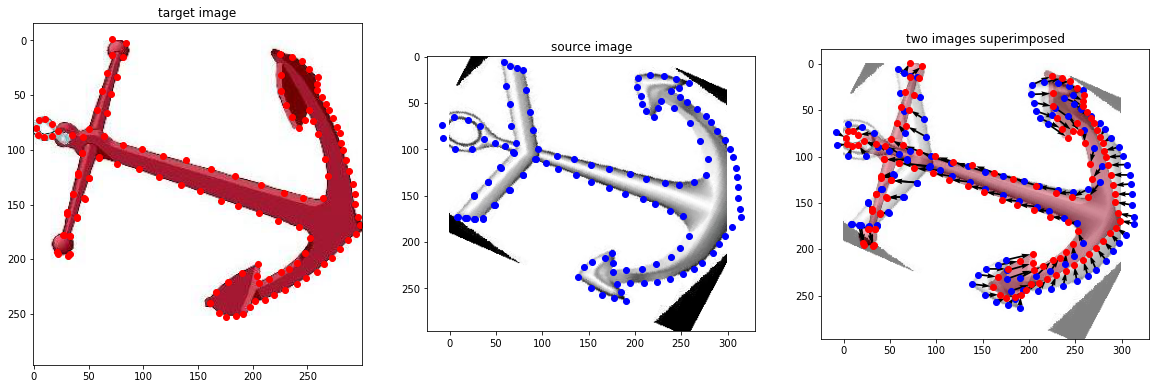

In [95]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Iref[:,cutil,:][rutil]);
plt.plot(PrefA[0,PtsInd],PrefA[1,PtsInd],'or')
plt.title('target image')

plt.subplot(1,3,2)
plt.imshow(Jreg)
plt.plot(PregA[0,PtsInd],PregA[1,PtsInd],'ob')
plt.title('source image')

plt.subplot(1,3,3)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(Jreg,alpha=0.5)
plt.plot(PregA[0,PtsInd],PregA[1,PtsInd],'ob')
plt.plot(PrefA[0,PtsInd],PrefA[1,PtsInd],'or')
plt.quiver(PregA[0,PtsInd],PregA[1,PtsInd],PrefA[0,PtsInd]-PregA[0,PtsInd],PrefA[1,PtsInd]-PregA[1,PtsInd],scale=400,angles='xy')

plt.title('two images superimposed')

plt.show()


#### Computation of non linear registration - small deformations

You can find below the parameters of the gaussian kernel. You can change these values after having computed everything.
Keep these variable's names in your code.

In [96]:
## To PLAY WITH
gam = 1 #0.001 #0.5
sigma = 30

**Instructions:**

- Compute **K the gaussian kernel** of the global deformation of your selected landmarks. 
- Compute the **momenta alphaX and alphaY**. You will need these estimated to compute all your next displacement vectors.  
- Compute **gammaX and gammaY** the displacement of your landmarks along vector v(landmark).


In [97]:
'''
TO DO:
Compute K gaussian kernel (use previously defined parameters gam and sigma),
momenta alphaX, alphaY and the displacement vector of each landmark, given by gammaX and gammaY.
----
K : array Npts x Npts (Npts is the number of landmarks you have)
alphaX : array Npts x 1
alphaY : array Npts x 1
(or compute directly alpha: array Npts x 2 )

gammaX : array Npts x 1
gammaY : array Npts x 1

'''

X = PregA 
Y = PrefA 

n = len(PtsInd) 
K = np.zeros((n, n)) 
for i in range(n): 
    for j in range(n): 
        K[i][j] = np.exp(- ((X[0][i] - X[0][j])**2 + (X[1][i] - X[1][j])**2) / sigma**2) 

alpha  = np.matmul(inv(K + gam*np.identity(n)), np.transpose(Y - X)) 
alphaX = np.zeros((n, 1)) 
alphaY = np.zeros((n, 1)) 
for i in range(n): 
    alphaX[i] = alpha[i][0] 
    alphaY[i] = alpha[i][1] 

gammaX = np.zeros((n, 1)) 
gammaY = np.zeros((n, 1)) 
for i in range(n): 
    for j in range(n): 
        gammaX[i] += K[i][j] * alphaX[j] 
        gammaY[i] += K[i][j] * alphaY[j] 

**Instructions:**

- Compute below the deformation kernel Kr of a grid defined by xim and yim, which has the same size than the source image.
- Code the displacement vectors gX and gY of this grid. 
- Find the original position (in the source image) of registered points, by computing inverse transformation of this grid (Section 3.1.2 of lectures).

In [98]:
##################################################
# This code computes a grid given by two vectors:
# xim : nr*nc by 1 (x coordinates)
# yim : nr*nc by 1 (y coordinates)
# These vectors are used to find the corresponding position of each pixel between the source image and the registered image.
xim,yim = np.meshgrid(np.arange(0,nc),np.arange(0,nr))
xim = xim.reshape(-1,1)
yim = yim.reshape(-1,1)


'''
TO DO :

Compute the kernel values Kr, and by following the displacement vectors gX and gY of the grid points (using alphaX and alphaY computed above).
Then compute the inverse transformation of the grid points (xim,yim) in RegInvX, regInvY.
-----
Kr : array nr*nc x Npts
gX : array nr*nc x 1
gY : array nr*nc x 1
RegInvX : array nr*nc x 1
RegInvY : array nr*nc x 1

'''

n1 = len(PtsInd) 
n2 = len(xim) 

Kr = np.zeros((n2, n1)) 
for i in range(n2): 
    for j in range(n1): 
        Kr[i][j] = np.exp(- ((xim[i] - X[0][j])**2 + (yim[i] - X[1][j])**2) / sigma**2) 

gX = np.zeros((n2, 1)) 
gY = np.zeros((n2, 1)) 
for i in range(n2): 
    for j in range(n1): 
        gX[i] += Kr[i][j] * alphaX[j] 
        gY[i] += Kr[i][j] * alphaY[j] 

RegInvX = xim - gX 
RegInvY = yim - gY 

##############################
# This code computes the registered image by finding the correspondence 
# between a source pixel and its position in the registered image.
# For each pixel i of gridReg in the target image space :
# 1. find the corresponding pixel in the source image JregA (position given by RegInvX[i] and RegInvY)
# 2. assign this source pixel value to the corresponding registered pixel in Jreg (the registered image).
# We obtain JregNL, the registered image.

JregNL = np.zeros((nr,nc,3))
for i in range(xim.shape[0]):
    value = JregA[int(round(RegInvY[i,0]) + nr), int(round(RegInvX[i,0]) + nc),:]
    JregNL[yim[i],xim[i],:] = value


#### The displacement field (optional)


If you want to observe the displacement field of a regular grid you can compute here the kernel of a regular grid, and the associated displacement of points with `vX` and `vY`. \
Then to use the computed field, you can uncomment the corresponding line in plot code in the next cell.

In [99]:
# A grid with coordinates of pixels in a source image

xgrid,ygrid = np.meshgrid(np.arange(0,nc,20),np.arange(0,nr,20))
xgrid = xgrid.reshape(-1,1)
ygrid = ygrid.reshape(-1,1)

'''
TO DO:
Compute the kernel values Kgrid of the grid above and the associated displacement vectors.
-----
Kgrid: array len(xgrid) x Npts (Npts is the number of landmarks you consider)
vX: array len(xgrid) x 1
vY: array len(xgrid) x 1
''' 

n2 = len(xgrid) 

Kgrid = np.zeros((n2, n1)) 
for i in range(n2): 
    for j in range(n1): 
        Kgrid[i][j] = np.exp(- ((xgrid[i] - X[0][j])**2 + (ygrid[i] - X[1][j])**2) / sigma**2) 

vX = np.dot(Kgrid, alphaX)
vY = np.dot(Kgrid, alphaY)

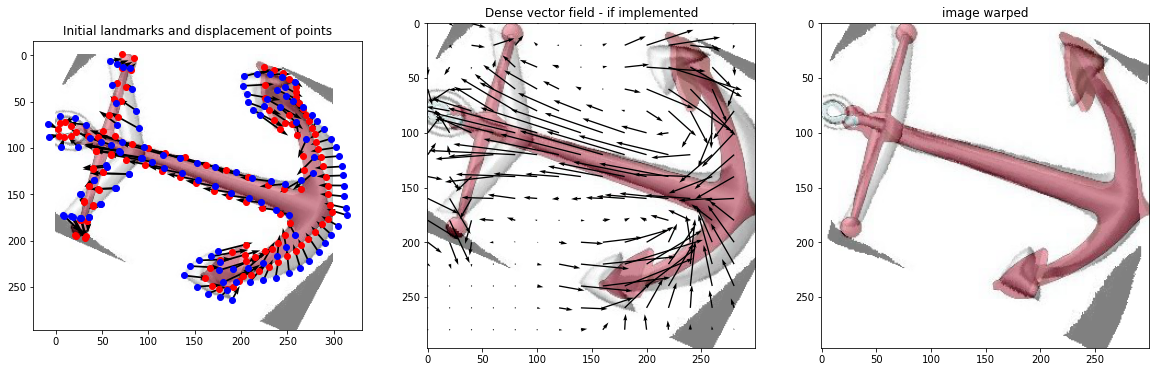

In [100]:
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(Iref[:,cutil,:][rutil]);
plt.imshow(JregA[:,cutil,:][rutil],alpha=0.5)
plt.plot(PrefA[0,PtsInd],PrefA[1,PtsInd],'or')
plt.plot(PregA[0,PtsInd],PregA[1,PtsInd],'ob')
plt.quiver(PregA[0,PtsInd],PregA[1,PtsInd],gammaX.T,gammaY.T,scale=200,angles='xy')
plt.title('Initial landmarks and displacement of points')


plt.subplot(1,3,2)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(JregA[:,cutil,:][rutil],alpha=0.5)
######## HERE
plt.quiver(xgrid,ygrid, vX, vY,angles='xy',scale=100) # line to uncomment if you want an overall displacement field, after coding it in the previous cell.
###############
plt.title('Dense vector field - if implemented')

plt.subplot(1,3,3)
plt.imshow(Iref[:,cutil,:][rutil])
plt.imshow(JregNL,alpha=0.5)
plt.title('image warped')

plt.show()

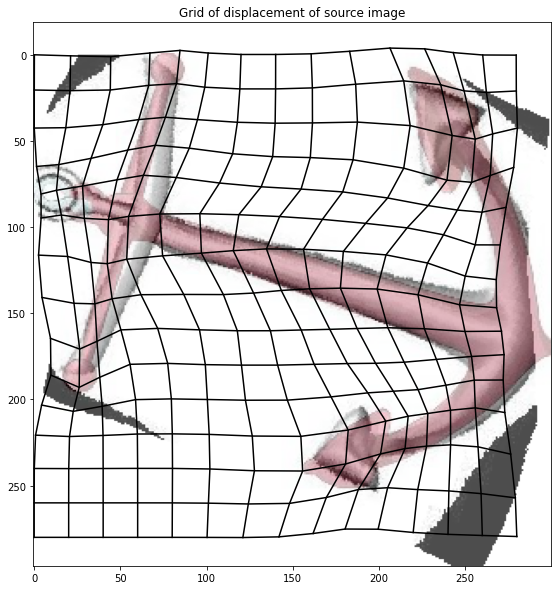

In [101]:
###############
# !!!!! You can run this if you implemented the displacement field vectors vX and vY.

fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(111) 
axes.imshow(Iref[:,cutil,:][rutil]) #plot the red anchor
axes.imshow(JregNL,alpha=0.7) #plot the registered grey anchor
plot_grid_def(nr,nc,vX,vY,axes=axes)

axes.title.set_text('Grid of displacement of source image')


**Again play with parameters and set of landmarks**. 

**Try to retrieve the different behaviors seen in class.**

**Q: How is this registration compared to the affine one ?  What can you say about the whole session, your understanding ?** 

Comparing to the affine registration of which local deformation are not matched at all (such as the 4 branches of anchor), this non-linear registration fixed this problem and local deformations are performed much better while preversing the global deformation. Overall, this non-linear registration gives a better result than the affine registration. 

My understanding is solid. 